# Neuronales Netz zur Vorhersage von Fahrtkosten

Fragestellung: Prognostizieren von Fahrtkosten: Wie teuer ist eine Fahrt, wenn ich in einer bestimmten Zone zu einer bestimmten Zeit einsteige?
Als Datenbasis für das Training werden die Taxisdaten aus dem Jahr 2019 verwendet.
In der Folge werden hierfür zwei Testfälle betrachtet. In dem einen ersten werden die Taxidaten aus dem Jahr 2019 aufgeteilt, sodass ein Teil der Daten als Testdaten verwendet werden.
In dem zweiten Fall werden die Daten aus einem zukünftigen Monat verwendet.

## Laden der Daten


Zuerst werden die Daten aus der csv-Datei geladen. Hiefür wurde vorher seitens der Gruppe eine vorbearbeitete csv Datei verwendet.

In [2]:
import den as den
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import tensorflow as tf
from tensorflow import keras
import time
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

input_data = pd.read_csv("../data/taxi_data/randomized_aggregated_for_one_year.csv", nrows=100000)
input_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,trip_times (min),pickup_times (unix),Speed (mph)
0,1,2019-01-23 12:08:54,2019-01-23 12:36:03,1.0,4.10,1.0,N,246,236,1,...,0.5,2.00,0.0,0.3,22.30,0.0,NaN,27.150000,1.548242e+09,9.060773
1,2,2019-01-20 13:16:06,2019-01-20 13:40:15,1.0,15.62,1.0,N,132,80,1,...,0.5,10.82,0.0,0.3,54.12,NaN,NaN,24.150000,1.547987e+09,38.807453
2,1,2019-01-18 10:21:51,2019-01-18 10:26:09,1.0,0.90,1.0,N,238,239,2,...,0.5,0.00,0.0,0.3,6.30,NaN,NaN,4.300000,1.547803e+09,12.558140
3,1,2019-01-14 12:13:59,2019-01-14 12:29:35,1.0,1.90,1.0,N,237,164,1,...,0.5,2.45,0.0,0.3,14.75,NaN,NaN,15.600000,1.547464e+09,7.307692
4,2,2019-01-09 19:56:34,2019-01-09 19:58:38,1.0,0.45,1.0,N,42,42,1,...,0.5,0.00,0.0,0.3,5.80,NaN,NaN,2.066667,1.547060e+09,13.064516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,2019-01-14 12:52:40,2019-01-14 13:08:35,1.0,3.70,1.0,N,246,88,1,...,0.5,3.15,0.0,0.3,18.95,NaN,NaN,15.916667,1.547467e+09,13.947644
99996,1,2019-01-26 02:57:35,2019-01-26 03:04:22,1.0,2.40,1.0,N,148,233,1,...,0.5,1.00,0.0,0.3,10.80,0.0,NaN,6.783333,1.548468e+09,21.228501
99997,2,2019-01-10 16:57:44,2019-01-10 17:16:32,1.0,1.73,1.0,N,234,237,1,...,0.5,3.58,0.0,0.3,17.88,NaN,NaN,18.800000,1.547136e+09,5.521277
99998,2,2019-01-03 13:36:48,2019-01-03 13:56:15,1.0,2.03,1.0,N,186,161,1,...,0.5,4.00,0.0,0.3,17.80,NaN,NaN,19.450000,1.546519e+09,6.262211


## Preprocessing der Daten
Im nächsten Schritt werden die eingelesenen Daten vorbearbeitet. Wichtig ist es, dass null Werte gegen 0 ersetzt werden, auch werden die Datumswerte in Integer-Werte verändert. Zudem werden sämtliche String-Datentypen aus dem Dataframe entfernt.
Des Weiteren werden weitere Spalten angelegt, sodass die aktuelle Uhrzeit oder der aktuelle Monat mittels Integer wiedergegeben werden kann.

In [3]:
input_data['tpep_pickup_datetime'] = pd.to_datetime(input_data['tpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
input_data['tpep_dropoff_datetime'] = pd.to_datetime(input_data['tpep_dropoff_datetime'], format='%Y-%m-%d %H:%M:%S')
input_data['PULocationID'].fillna(-1, inplace=True)
input_data['DOLocationID'].fillna(-1, inplace=True)
input_data['tpep_pickup_month'] = input_data['tpep_pickup_datetime'].dt.month
input_data['tpep_dropoff_month'] = input_data['tpep_dropoff_datetime'].dt.month
input_data['tpep_pickup_day_numeric'] = input_data['tpep_pickup_datetime'].dt.day
input_data['tpep_dropoff_day_numeric'] = input_data['tpep_dropoff_datetime'].dt.day
input_data['tpep_pickup_day_name'] = input_data['tpep_pickup_datetime'].dt.day_name()
input_data['tpep_dropoff_day_name'] = input_data['tpep_dropoff_datetime'].dt.day_name()
input_data['tpep_pickup_hour'] = input_data['tpep_pickup_datetime'].dt.hour
input_data['tpep_dropoff_hour'] = input_data['tpep_dropoff_datetime'].dt.hour
input_data['tpep_pickup_day'] = input_data['tpep_pickup_datetime'].dt.strftime("%w").astype(int)
input_data['tpep_dropoff_day'] = input_data['tpep_dropoff_datetime'].dt.strftime("%w").astype(int)
input_data['tpep_pickup_datetime'] = input_data['tpep_pickup_datetime'].apply(lambda x: int(x.strftime('%Y%m%d')))
input_data['tpep_dropoff_datetime'] = input_data['tpep_dropoff_datetime'].apply(lambda x: int(x.strftime('%Y%m%d')))
input_data = input_data.fillna(0)
input_data = input_data.drop(["tpep_dropoff_day_name"], axis=1)
input_data = input_data.drop(["tpep_pickup_day_name"], axis=1)
input_data = input_data.drop(["store_and_fwd_flag"], axis=1)

input_data

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,Speed (mph),trip_duration,tpep_pickup_month,tpep_dropoff_month,tpep_pickup_day_numeric,tpep_dropoff_day_numeric,tpep_pickup_hour,tpep_dropoff_hour,tpep_pickup_day,tpep_dropoff_day
0,1,20190123,20190123,1.0,4.10,1.0,246,236,1,19.5,...,9.060773,1629,1,1,23,23,12,12,3,3
1,2,20190120,20190120,1.0,15.62,1.0,132,80,1,42.5,...,38.807453,1449,1,1,20,20,13,13,0,0
2,1,20190118,20190118,1.0,0.90,1.0,238,239,2,5.5,...,12.558140,258,1,1,18,18,10,10,5,5
3,1,20190114,20190114,1.0,1.90,1.0,237,164,1,11.5,...,7.307692,936,1,1,14,14,12,12,1,1
4,2,20190109,20190109,1.0,0.45,1.0,42,42,1,4.0,...,13.064516,124,1,1,9,9,19,19,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,20190114,20190114,1.0,3.70,1.0,246,88,1,15.0,...,13.947644,955,1,1,14,14,12,13,1,1
99996,1,20190126,20190126,1.0,2.40,1.0,148,233,1,8.5,...,21.228501,407,1,1,26,26,2,3,6,6
99997,2,20190110,20190110,1.0,1.73,1.0,234,237,1,12.5,...,5.521277,1128,1,1,10,10,16,17,4,4
99998,2,20190103,20190103,1.0,2.03,1.0,186,161,1,13.0,...,6.262211,1167,1,1,3,3,13,13,4,4


## Normalisierung der Daten
In diesem Abschnitt werden die Traingsdaten normalisiert. Im Anschluss werden diese in einen Trainings- sowie Testdatensatz aufgeteilt.

In [4]:
#Definition der Features und der TargetVariable (y)
Features = ['PULocationID', 'DOLocationID', 'tpep_pickup_month', 'tpep_pickup_day', 'tpep_pickup_hour']
TargetVariable = ['total_amount']

#laden der Daten in einen seperaten Dataframe
X = input_data[Features].values
y = input_data[TargetVariable].values

# definiert StandardScaler für das normalisieren Daten
PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

# identifiziert das minimum und maximum Daten für die spätere Transformation
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)

# transformiert die Daten (Normalisierung)
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)

#teilt die Daten in Test- und Traingsdaten auf (30% Testdaten, 70% Trainingsdaten)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(70000, 5)
(70000, 1)
(30000, 5)
(30000, 1)


## Modelldefintion für das Regressionsmodell

Modell zur Vorhersage von Fahrtkosten einzelnen Fahrten. Dafür wird nur eine Output-unit verwendet. Des Weiteren wird der mean squared error als loss-function verwendet, da es sich bei dem Modell um ein Regressionsmodell handelt. Die Parameter wurden durch testen identifiziert.


In [5]:
model = Sequential([
    Dense(units=32, input_dim=X_train.shape[1], activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=32, activation='relu'),
    Flatten(),
    Dense(units=1)
])
model.summary()

model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(x=X_train, y=y_train, batch_size=100, epochs=20, shuffle=True,
          verbose=2)




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
700/700 - 2s - loss: 0.9606 - mean_squared_

In [6]:
#Vorhersage mit dem Testdaten
Predictions = model.predict(X_test)

# die inversive Transformation der Vorhersagen, labeldaten und Testdaten
Predictions = TargetVarScalerFit.inverse_transform(Predictions)
y_test_orig = TargetVarScalerFit.inverse_transform(y_test)
Test_Data = PredictorScalerFit.inverse_transform(X_test)

#Erstellen eines neuen Dataframes mit den vorhergesagten Fahrtzeiten und den tatsächlichen Fahrtzeiten
TestingData = pd.DataFrame(data=Test_Data, columns=Features)
TestingData['total_amount'] = y_test_orig
TestingData['predicted amount'] = Predictions
TestingData.head(10)

938/938 [==============================] - 1s 950us/step


,PULocationID,DOLocationID,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,total_amount,predicted amount
0,79.0,164.0,1.0,2.0,7.0,10.3,14.882852
1,166.0,236.0,1.0,5.0,17.0,13.8,12.721217
2,140.0,238.0,1.0,4.0,23.0,16.6,15.908890
3,90.0,114.0,1.0,6.0,16.0,9.8,14.139895
4,142.0,142.0,1.0,0.0,12.0,5.3,11.757421
5,236.0,237.0,1.0,5.0,8.0,11.8,11.101406
6,50.0,90.0,1.0,1.0,19.0,12.3,15.687631
7,141.0,236.0,1.0,2.0,9.0,11.8,10.626025
8,161.0,162.0,1.0,6.0,17.0,7.3,8.757058
9,170.0,142.0,1.0,3.0,12.0,16.3,19.174681


## Zweiter Testdatensatz: Vorhersage für Fahrtkosten aus dem Jahr 2020 (Mai)
In dem diesem Abschnitt werden nun Testdaten aus dem Jahr 2020 verwendet. Für diese Testdaten soll das vorher erstellte Model nun Vorhersagen erstellen.

Im ersten Schritt wird die csv Datei geladen. Daraufhin wird ein identisches Preprocessing der Daten durchgeführt.

In [7]:
# Einlesen einer weiteren csv aus dem nächsten Jahr
input_test_data = pd.read_csv("../data/taxi_data/yellow_tripdata_2020-05.csv", nrows=50)

#Data preprocesssing
input_test_data['tpep_pickup_datetime'] = pd.to_datetime(input_test_data['tpep_pickup_datetime'],
                                                         format='%Y-%m-%d %H:%M:%S')
input_test_data['tpep_dropoff_datetime'] = pd.to_datetime(input_test_data['tpep_dropoff_datetime'],
                                                          format='%Y-%m-%d %H:%M:%S')
input_test_data['trip_duration'] = (
        input_test_data['tpep_dropoff_datetime'] - input_test_data['tpep_pickup_datetime']).dt.seconds
input_test_data['trip_times (min)'] = input_test_data['trip_duration'].apply(lambda x: x / 60)
input_test_data['PULocationID'].fillna(-1, inplace=True)
input_test_data['DOLocationID'].fillna(-1, inplace=True)
input_test_data['tpep_pickup_month'] = input_test_data['tpep_pickup_datetime'].dt.month
input_test_data['tpep_dropoff_month'] = input_test_data['tpep_dropoff_datetime'].dt.month
input_test_data['tpep_pickup_day_numeric'] = input_test_data['tpep_pickup_datetime'].dt.day
input_test_data['tpep_dropoff_day_numeric'] = input_test_data['tpep_dropoff_datetime'].dt.day
input_test_data['tpep_pickup_day_name'] = input_test_data['tpep_pickup_datetime'].dt.day_name()
input_test_data['tpep_dropoff_day_name'] = input_test_data['tpep_dropoff_datetime'].dt.day_name()
input_test_data['tpep_pickup_hour'] = input_test_data['tpep_pickup_datetime'].dt.hour
input_test_data['tpep_dropoff_hour'] = input_test_data['tpep_dropoff_datetime'].dt.hour
input_test_data['tpep_pickup_day'] = input_test_data['tpep_pickup_datetime'].dt.strftime("%w").astype(int)
input_test_data['tpep_dropoff_day'] = input_test_data['tpep_dropoff_datetime'].dt.strftime("%w").astype(int)
input_test_data['tpep_pickup_datetime'] = input_test_data['tpep_pickup_datetime'].apply(
    lambda x: int(x.strftime('%Y%m%d')))
input_test_data['tpep_dropoff_datetime'] = input_test_data['tpep_dropoff_datetime'].apply(
    lambda x: int(x.strftime('%Y%m%d')))
input_test_data = input_test_data.fillna(0)
input_test_data = input_test_data.drop(["tpep_dropoff_day_name"], axis=1)
input_test_data = input_test_data.drop(["tpep_pickup_day_name"], axis=1)
input_test_data = input_test_data.drop(["store_and_fwd_flag"], axis=1)
input_test_data



,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,...,trip_duration,trip_times (min),tpep_pickup_month,tpep_dropoff_month,tpep_pickup_day_numeric,tpep_dropoff_day_numeric,tpep_pickup_hour,tpep_dropoff_hour,tpep_pickup_day,tpep_dropoff_day
0,1,20200501,20200501,1.0,0.00,1.0,234,256,1,12.2,...,939,15.650000,5,5,1,1,0,0,5,5
1,1,20200501,20200501,2.0,0.40,1.0,264,264,1,4.0,...,160,2.666667,5,5,1,1,0,0,5,5
2,1,20200501,20200501,1.0,0.30,1.0,264,264,2,3.5,...,133,2.216667,5,5,1,1,0,0,5,5
3,1,20200501,20200501,1.0,1.70,1.0,107,229,2,7.0,...,336,5.600000,5,5,1,1,0,0,5,5
4,1,20200501,20200501,0.0,0.90,1.0,237,262,1,6.0,...,367,6.116667,5,5,1,1,0,1,5,5
5,1,20200501,20200501,0.0,12.00,1.0,140,28,1,35.5,...,1471,24.516667,5,5,1,1,0,1,5,5
6,1,20200501,20200501,1.0,2.90,1.0,79,237,2,12.0,...,1078,17.966667,5,5,1,1,0,0,5,5
7,1,20200501,20200501,1.0,1.50,1.0,140,263,1,7.0,...,370,6.166667,5,5,1,1,0,0,5,5
8,1,20200501,20200501,1.0,2.00,1.0,140,230,2,9.0,...,589,9.816667,5,5,1,1,0,1,5,5
9,1,20200501,20200501,1.0,0.50,1.0,239,239,2,4.5,...,204,3.400000,5,5,1,1,0,0,5,5


## Normalisierung der Daten
In diesem Schritt wird analog zu der vorherigen Normalisierung vorgegenagen. Nur in diesem Fall ist es nicht notwenig die labels seperat zu transformieren.

In [12]:
#laden der Daten in einen seperaten Dataframe
X_test_features = input_test_data[Features].values
y_test_target = input_test_data[TargetVariable].values

# definiert StandardScaler für das normalisieren Daten
test_PredictorScaler = StandardScaler()
test_TargetVarScaler = StandardScaler()

# identifiziert das minimum und maximum Daten für die spätere Transformation
test_TargetVarScalerFit = test_TargetVarScaler.fit(y_test_target)
test_PredictorScaler = test_PredictorScaler.fit(X_test_features)

# Transformation der Testdaten
X_test_features = test_PredictorScaler.transform(X_test_features)





In [13]:
# vorhersage mit den Testdaten
second_predictions = model.predict(X_test_features)

# die inversive Transformation der Vorhersagen und Testdaten
second_predictions = test_TargetVarScaler.inverse_transform(second_predictions)
second_Test_Data = test_PredictorScaler.inverse_transform(X_test_features)

#Erstellen eines neuen Dataframes mit den vorhergesagten Fahrtzeiten und den tatsächlichen Fahrtzeiten
second_TestingData = pd.DataFrame(data=second_Test_Data, columns=Features)
second_TestingData['total_amount'] = y_test_target
second_TestingData['predicted amount'] = second_predictions
second_TestingData.head(30)

2/2 [==============================] - 0s 2ms/step


,PULocationID,DOLocationID,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,total_amount,predicted amount
0,234.0,256.0,5.0,5.0,0.0,18.40,11.827549
1,264.0,264.0,5.0,5.0,0.0,5.80,12.858894
2,264.0,264.0,5.0,5.0,0.0,4.80,12.858894
3,107.0,229.0,5.0,5.0,0.0,10.80,13.995835
4,237.0,262.0,5.0,5.0,0.0,11.00,11.952574
5,140.0,28.0,5.0,5.0,0.0,39.30,14.075544
6,79.0,237.0,5.0,5.0,0.0,15.80,13.525948
7,140.0,263.0,5.0,5.0,0.0,12.95,12.735464
8,140.0,230.0,5.0,5.0,0.0,12.80,10.908864
9,239.0,239.0,5.0,5.0,0.0,8.30,12.238553


## Visualisierung der Ergebnisse
Nun
werden
die
vorhergesagten
Fahrtzeiten
mit
den
tatsächlichen
Fahrtzeiten
gegenüber
gestellt

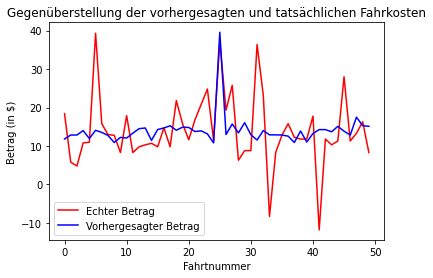

<Figure size 72000x72000 with 0 Axes>

In [18]:
plt.plot(second_TestingData['total_amount'], color='red', label='Echter Betrag')
plt.plot(second_TestingData['predicted amount'], color='blue', label='Vorhergesagter Betrag')
plt.title('Gegenüberstellung der vorhergesagten und tatsächlichen Fahrkosten')
plt.xlabel('Fahrtnummer')
plt.ylabel('Betrag (in $)')
plt.legend()
plt.figure(figsize=(1000, 1000))
plt.show()




<AxesSubplot:xlabel='total_amount', ylabel='predicted amount'>

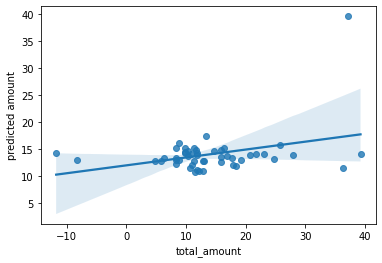

In [16]:
sn.regplot(x='total_amount', y='predicted amount', data=second_TestingData)
